# BEM114 Homework 2 - Statistical Arbitrage
**Names:** Andrew Zabelo, Daniel Wen, Kyle McCandless  
**UIDs:** , , 2157818

## Setup

In [ ]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm


## Problem 1
### Part A

In [ ]:
# Read data and clean
df = pd.read_csv('crsp_1926_2020.csv')

# Drop NaNs, set types
df = df.dropna()
df = df.astype({'date': 'string', 'SHRCD': 'int', 'EXCHCD': 'int'})

# Follow part A instructions
df = df[df['SHRCD'].isin([10, 11])]
df = df[df['EXCHCD'].isin([1, 2, 3])]
df.loc[df['PRC'] < 0, 'PRC'] = 'NA'
df

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT
1,10000,1986-01-31,10,3,NA,C,3680.0
2,10000,1986-02-28,10,3,NA,-0.257143,3680.0
3,10000,1986-03-31,10,3,NA,0.365385,3680.0
4,10000,1986-04-30,10,3,NA,-0.098592,3793.0
5,10000,1986-05-30,10,3,NA,-0.222656,3793.0
...,...,...,...,...,...,...,...
4705164,93436,2020-08-31,11,3,498.32001,0.741452,931809.0
4705165,93436,2020-09-30,11,3,429.01001,-0.139087,948000.0
4705166,93436,2020-10-30,11,3,388.04001,-0.095499,947901.0
4705167,93436,2020-11-30,11,3,567.59998,0.462736,947901.0


### Part B

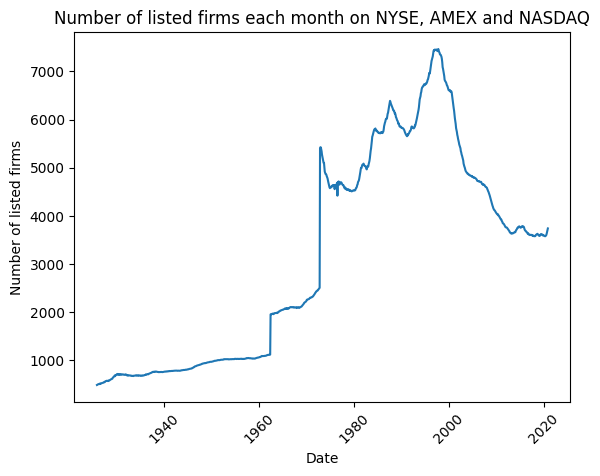

In [ ]:
# Group by year and month
df['YYYY-MM'] = df['date'].str[:-3]
by_month = df.groupby(df['YYYY-MM'])['PERMNO'].nunique().reset_index()
by_month['YYYY-MM'] = pd.to_datetime(by_month['YYYY-MM'])

# Create plot of number of firms listed each month
plt.plot(by_month['YYYY-MM'], by_month['PERMNO'])
plt.title('Number of listed firms each month on NYSE, AMEX and NASDAQ')
plt.xlabel('Date')
plt.ylabel('Number of listed firms')
plt.xticks(rotation=45)
plt.show()

## Problem 2

In [ ]:
# Given a group of stocks, calculate value weights
def calc_weights(group):
    # Calc equal weights
    group['weights_eq'] = 1 / float(group['decile'].count())
    # Calc total market equity of group
    group['TMV'] = group['MV'].sum()
    # Calc value weights
    group['weights_val'] = group['MV'] / group['TMV']
    return group

In [ ]:
# Load FF3 factors
ff3 = pd.read_csv('F-F_Research_Data_Factors.CSV')

df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df['PRC'] = df['PRC'].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['PRC'])
df['date'] = np.floor(df['date'].str.replace('-','').astype(float)/100).astype(int)
df


/var/folders/wc/bjtjbszx27s7y1w8qfl73z7w0000gn/T/ipykernel_14487/505373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = np.floor(df['date'].str.replace('-','').astype(float)/100).astype(int)


,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT,YYYY-MM
28,10001,198609,11,3,6.37500,-0.003077,991.0,1986-09
29,10001,198610,11,3,6.62500,0.039216,991.0,1986-10
30,10001,198611,11,3,7.00000,0.056604,991.0,1986-11
31,10001,198612,11,3,7.00000,0.015000,991.0,1986-12
32,10001,198701,11,3,6.75000,-0.035714,991.0,1987-01
...,...,...,...,...,...,...,...,...
4705164,93436,202008,11,3,498.32001,0.741452,931809.0,2020-08
4705165,93436,202009,11,3,429.01001,-0.139087,948000.0,2020-09
4705166,93436,202010,11,3,388.04001,-0.095499,947901.0,2020-10
4705167,93436,202011,11,3,567.59998,0.462736,947901.0,2020-11


In [ ]:
df['MV'] = df['PRC'] * df['SHROUT']
sortdf = df.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT'], axis=1)
sortdf['rank'] = sortdf.groupby('date')['MV'].rank(pct=True)

# Label decile portfolios
sortdf['decile'] = np.ceil(sortdf['rank']*10)

# Calculate weights
# Introduces Nans because some rows do not have BM_decile
sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)

# Move weights and deciles forward one month
# We form portfolios at the end of this month, and then earn returns over
# the next month.
sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)

/var/folders/wc/bjtjbszx27s7y1w8qfl73z7w0000gn/T/ipykernel_14487/3598337515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MV'] = df['PRC'] * df['SHROUT']
/var/folders/wc/bjtjbszx27s7y1w8qfl73z7w0000gn/T/ipykernel_14487/3598337515.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)


In [ ]:
# =============================================================================
#     5) Calculate weighted returns
#
#
# =============================================================================

# Calculate weights times returns
sortdf['weighted_val_ret'] = sortdf['weights_val_lag'] * sortdf['RET']
sortdf['weighted_eq_ret'] = sortdf['weights_eq_lag'] * sortdf['RET']

# Sum up portfolio returns
eqports = sortdf.groupby(['date', 'decile_lag'])['weighted_eq_ret'].sum()
eqports = eqports.unstack()
# Missing accounting data in early years
eqports = eqports.dropna(axis=0)
# Match data format of FF factors
eqports = eqports * 100
eqports = eqports.reset_index()

valports = sortdf.groupby(['date', 'decile_lag'])['weighted_val_ret'].sum()
valports = valports.unstack()
valports = valports.dropna(axis=0)
valports = valports * 100
valports = valports.reset_index()

eqports


decile_lag,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,192601,11.782215,1.830621,1.372321,3.038145,-0.275138,0.665188,-0.346502,0.457743,-0.197943,-0.193838
1,192602,-7.953088,-5.468666,-9.648219,-6.952050,-6.707273,-6.873791,-5.925456,-6.218172,-3.216784,-2.266515
2,192603,-17.366330,-14.768564,-13.770322,-10.571645,-10.750652,-10.258181,-12.519652,-5.036840,-7.028057,-6.620769
3,192604,0.934766,1.574623,0.309830,4.592213,4.434697,2.758254,5.305059,2.897505,3.691636,3.286036
4,192605,-3.108273,-0.567706,2.505172,0.644207,-1.212357,2.046563,1.193787,0.845630,0.955320,1.810399
...,...,...,...,...,...,...,...,...,...,...,...
1135,202008,-0.485998,1.913876,6.096398,7.985668,6.533205,6.202248,5.482641,5.480806,5.010431,4.332389
1136,202009,-1.173155,-0.764958,-2.175105,-2.597382,-4.539896,-3.893649,-3.622940,-3.931072,-1.355803,-1.832027
1137,202010,0.943012,-1.614138,-0.961324,0.661733,1.554059,2.092947,3.643933,2.556817,0.912083,-1.139210
1138,202011,27.361794,22.952993,23.495268,24.257942,21.846842,21.050520,19.772252,17.144183,15.526824,13.012835


In [ ]:
ff1992 = pd.merge(ff1992, ff3, how='inner', on=['date'])
ff1992

,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,10-1,Mkt-RF,SMB,HML,RF
0,192607,-2.900300,0.664204,3.080425,1.090265,2.413819,1.755117,1.717843,1.690862,4.364433,3.344747,-6.245047,2.96,-2.56,-2.43,0.22
1,192608,8.631533,6.659466,0.974191,7.876926,3.960977,1.586322,2.928652,1.113579,1.647911,3.935321,4.696212,2.64,-1.17,3.82,0.25
2,192609,-0.097095,-4.013220,-0.242044,0.997787,-2.177489,1.253843,-2.778821,0.329236,-0.618539,0.863038,-0.960132,0.36,-1.40,0.13,0.23
3,192610,1.545416,-6.525443,-1.462605,-0.640073,-3.493012,-3.151983,-2.106130,-2.549409,-4.044516,-2.206805,3.752222,-3.24,-0.09,0.70,0.32
4,192611,0.988902,1.327599,1.796903,8.256913,7.414863,3.243924,4.252399,3.048159,4.918873,3.009746,-2.020844,2.53,-0.10,-0.51,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,202008,-0.485998,1.913876,6.096398,7.985668,6.533205,6.202248,5.482641,5.480806,5.010431,4.332389,-4.818387,7.63,-0.22,-2.97,0.01
1130,202009,-1.173155,-0.764958,-2.175105,-2.597382,-4.539896,-3.893649,-3.622940,-3.931072,-1.355803,-1.832027,0.658872,-3.63,0.02,-2.71,0.01
1131,202010,0.943012,-1.614138,-0.961324,0.661733,1.554059,2.092947,3.643933,2.556817,0.912083,-1.139210,2.082222,-2.10,4.38,4.25,0.01
1132,202011,27.361794,22.952993,23.495268,24.257942,21.846842,21.050520,19.772252,17.144183,15.526824,13.012835,14.348959,12.47,5.80,2.09,0.01


In [ ]:
# =============================================================================
#     6) Replicate FF 1992
#
#
# =============================================================================


# Calculate average returns
ff1992 = eqports.copy()
# ff1992 = eqports
# Check average returns
ff1992.mean()

# Form Long-Short Portfolio
ff1992['10-1'] = ff1992[1] - ff1992[10]


# HML
strat = '10-1'
# Calc mean, vol, and sharpe
stratmean = ff1992[strat].mean()
stratvol = ff1992[strat].std()
stratsharpe = stratmean/stratvol
print("Strategy {} has mean {}, vol {}, and Sharpe {}".format(strat, stratmean, stratvol, stratsharpe))


# CAPM
# # Get FF3 factors
ff1992 = pd.merge(ff1992, ff3, how='inner', on=['date'])
# Estimate CAPM
model1=sm.OLS(ff1992[strat] ,
              sm.add_constant(ff1992[['Mkt-RF']])).fit()
print(model1.summary())


# # Estimate FF3
model1=sm.OLS(ff1992[strat],
              sm.add_constant(ff1992[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

Strategy 10-1 has mean 2.196465045619146, vol 15.065437159855007, and Sharpe 0.14579497576559441
                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     231.4
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.08e-47
Time:                        14:48:51   Log-Likelihood:                -4581.1
No. Observations:                1134   AIC:                             9166.
Df Residuals:                    1132   BIC:                             9176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [ ]:




# =============================================================================
#     7) Replicate FF 1992 (Value Weighted)
#
#
# =============================================================================


# Calculate average returns
ff1992 = valports.copy()
# ff1992 = valports.copy()
# Check average returns
ff1992.mean()

# Estimate CAPM
ff1992['10-1'] = ff1992[1] - ff1992[10]


# HML
strat = '10-1'
# Calc mean, vol, and sharpe
stratmean = ff1992[strat].mean()
stratvol = ff1992[strat].std()
stratsharpe = stratmean/stratvol
print("Strategy {} has mean {}, vol {}, and Sharpe {}".format(strat, stratmean, stratvol, stratsharpe))


# CAPM
# Get FF3 factors
ff1992 = pd.merge(ff1992, ff3, how='inner', on=['date'])
# Estimate CAPM
model1=sm.OLS(ff1992[strat] ,
              sm.add_constant(ff1992[['Mkt-RF']])).fit()
print(model1.summary())


# Estimate FF3
model1=sm.OLS(ff1992[strat],
              sm.add_constant(ff1992[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

# HML on CAPM
model1=sm.OLS(ff1992['HML'] ,
              sm.add_constant(ff1992[['Mkt-RF']])).fit()
print(model1.summary())

Strategy 10-1 has mean 1.5678189607302107, vol 12.93038603178765, and Sharpe 0.12125074664251588
                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     274.1
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           2.66e-55
Time:                        14:54:39   Log-Likelihood:                -4390.0
No. Observations:                1134   AIC:                             8784.
Df Residuals:                    1132   BIC:                             8794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Problem 3

## Problem 4